#Lab11_6 RNN Packed Sequence

Sequential Data

대표적으로 text data, audio data

text data 처리할 때 가장 많이 쓰는 방법 : **padding**

가장 긴 sequence 길이에 맞춰 나머지 데이터의 뒷부분을 <pad>라는 토큰을 써서 표현 -> 컴퓨터에서 처리하기 편리, but 필요없는 부분까지 쓰는 것이어서 비효율적

**packing**

padding을 사용하지 않는다. packing을 사용하려면 sequence를 내림차순으로 정렬해야 한다. -> 계산 효율적, pad token을 쓰지 않아도 됨 but 구현 시 padding에 비해 조금 더 복잡함

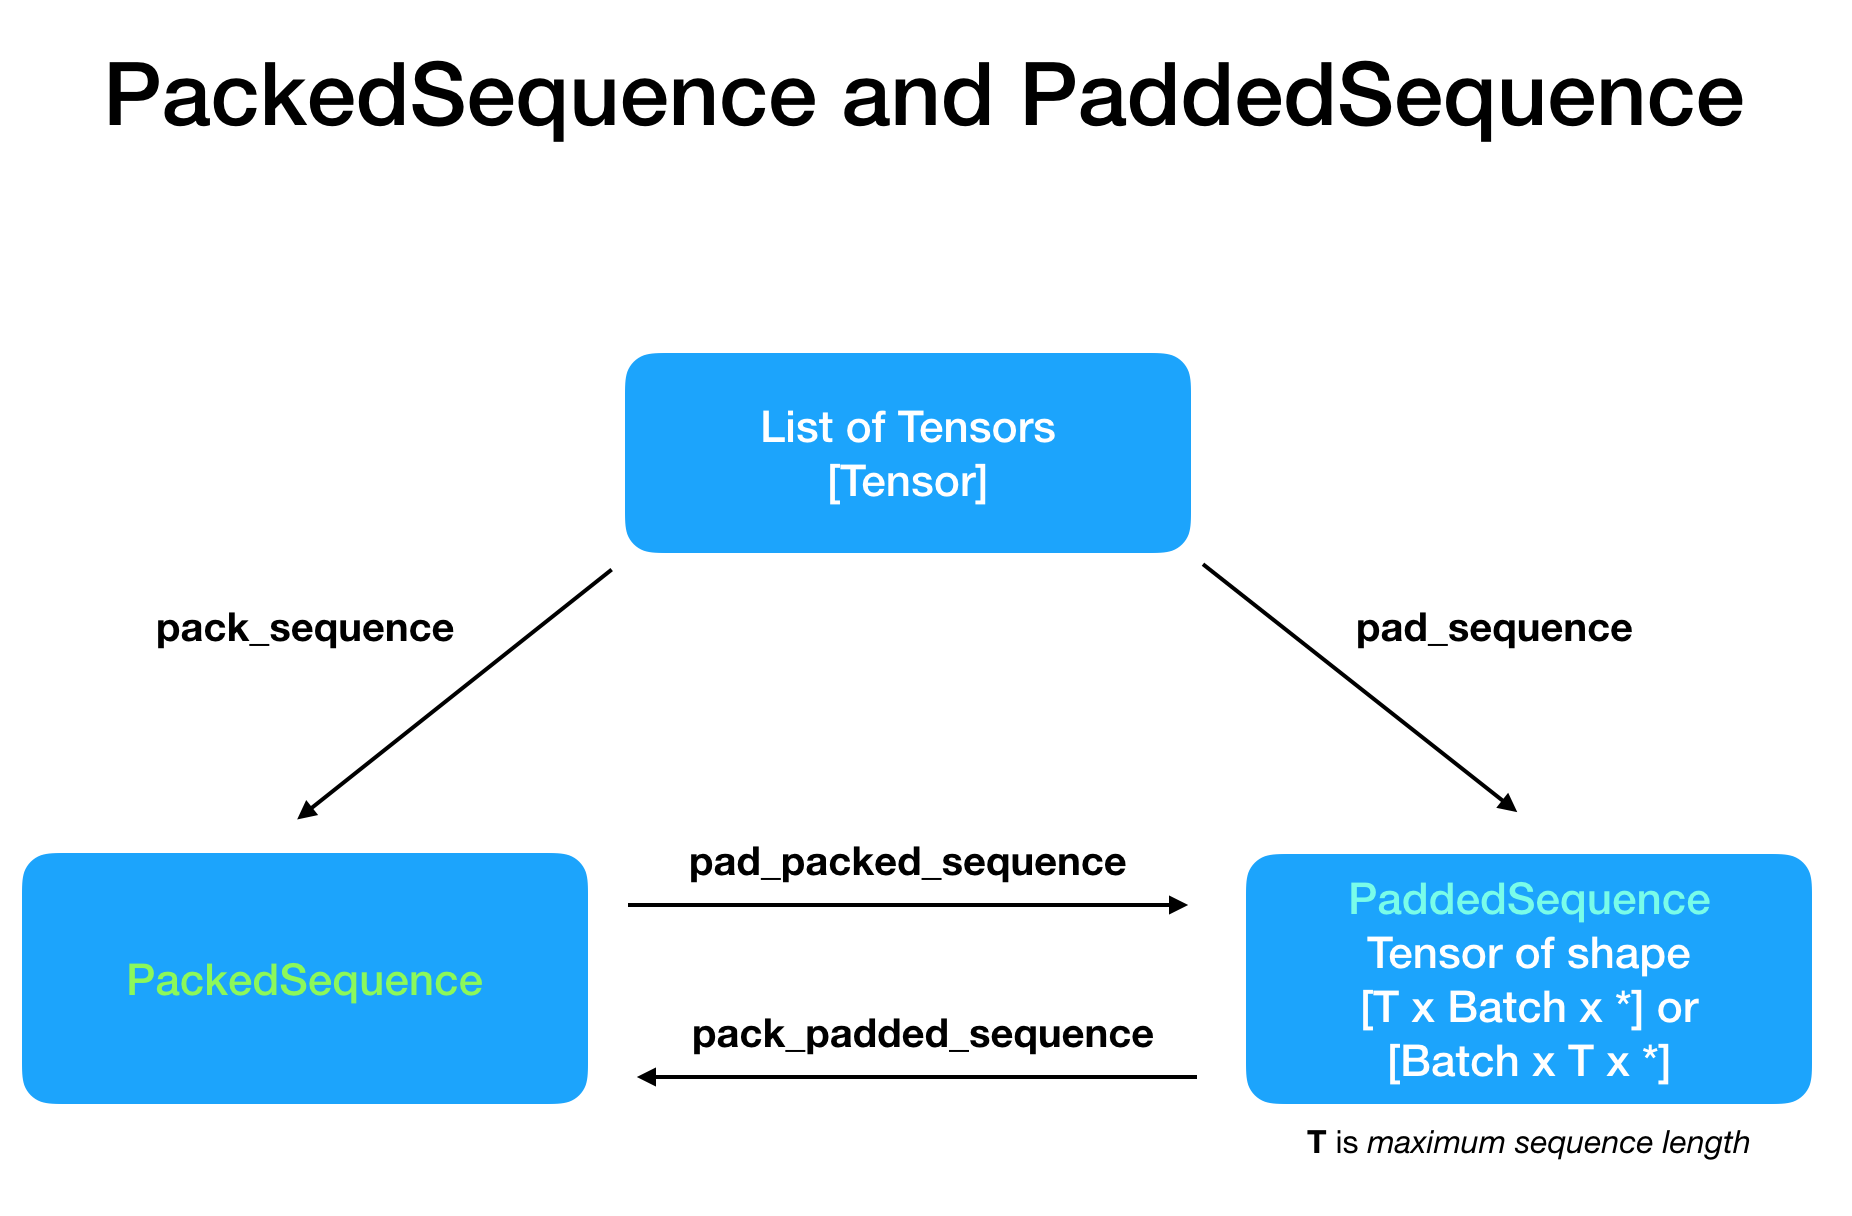

## Sequence 만들기

In [3]:
import torch
import numpy as np
from torch.nn.utils.rnn import pad_sequence, pack_sequence, pack_padded_sequence, pad_packed_sequence

In [1]:
# Random word from random word generator
data = ['hello world',
        'midnight',
        'calculation',
        'path',
        'short circuit']

# Make dictionary
char_set = ['<pad>'] + list(set(char for seq in data for char in seq)) # Get all characters and include pad token
char2idx = {char: idx for idx, char in enumerate(char_set)} # Constuct character to index dictionary
print('char_set:', char_set)
print('char_set length:', len(char_set))

char_set: ['<pad>', 'i', 's', 'e', 'o', 'h', 'l', 'r', 'n', 'g', 'm', 'd', 't', 'u', 'c', ' ', 'w', 'p', 'a']
char_set length: 19


In [4]:
# Convert character to index and make list of tensors
X = [torch.LongTensor([char2idx[char] for char in seq]) for seq in data]

# Check converted result
for sequence in X:
    print(sequence)

tensor([ 5,  3,  6,  6,  4, 15, 16,  4,  7,  6, 11])
tensor([10,  1, 11,  8,  1,  9,  5, 12])
tensor([14, 18,  6, 14, 13,  6, 18, 12,  1,  4,  8])
tensor([17, 18, 12,  5])
tensor([ 2,  5,  4,  7, 12, 15, 14,  1,  7, 14, 13,  1, 12])


sequence 길이가 제각각이다!

In [5]:
# Make length tensor (will be used later in 'pack_padded_sequence' function)
lengths = [len(seq) for seq in X]
print('lengths:', lengths)

lengths: [11, 8, 11, 4, 13]


Sequence 데이터 batch로 묶기

- 제일 긴 sequence 길이에 맞춰 뒷부분에 padding 추가 -> PaddedSequence

- padding을 추가하지 않고 정확히 주어진 sequence 길이까지만 모델이 연산을 하게 함 -> PackedSequence



## PaddedSequence

In [6]:
# Make a Tensor of shape (Batch x Maximum_Sequence_Length)
padded_sequence = pad_sequence(X, batch_first=True) # X is now padded sequence
print(padded_sequence)
print(padded_sequence.shape)

tensor([[ 5,  3,  6,  6,  4, 15, 16,  4,  7,  6, 11,  0,  0],
        [10,  1, 11,  8,  1,  9,  5, 12,  0,  0,  0,  0,  0],
        [14, 18,  6, 14, 13,  6, 18, 12,  1,  4,  8,  0,  0],
        [17, 18, 12,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 2,  5,  4,  7, 12, 15, 14,  1,  7, 14, 13,  1, 12]])
torch.Size([5, 13])


## PackedSequence

In [7]:
# Sort by descending lengths
sorted_idx = sorted(range(len(lengths)), key=lengths.__getitem__, reverse=True)
sorted_X = [X[idx] for idx in sorted_idx]

# Check converted result
for sequence in sorted_X:
    print(sequence)

tensor([ 2,  5,  4,  7, 12, 15, 14,  1,  7, 14, 13,  1, 12])
tensor([ 5,  3,  6,  6,  4, 15, 16,  4,  7,  6, 11])
tensor([14, 18,  6, 14, 13,  6, 18, 12,  1,  4,  8])
tensor([10,  1, 11,  8,  1,  9,  5, 12])
tensor([17, 18, 12,  5])


In [8]:
packed_sequence = pack_sequence(sorted_X)
print(packed_sequence)

PackedSequence(data=tensor([ 2,  5, 14, 10, 17,  5,  3, 18,  1, 18,  4,  6,  6, 11, 12,  7,  6, 14,
         8,  5, 12,  4, 13,  1, 15, 15,  6,  9, 14, 16, 18,  5,  1,  4, 12, 12,
         7,  7,  1, 14,  6,  4, 13, 11,  8,  1, 12]), batch_sizes=tensor([5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 3, 1, 1]), sorted_indices=None, unsorted_indices=None)


## Embedding 적용하기

one-hot character embedding

In [9]:
# one-hot embedding using PaddedSequence
eye = torch.eye(len(char_set)) # Identity matrix of shape (len(char_set), len(char_set))
embedded_tensor = eye[padded_sequence]
print(embedded_tensor.shape) # shape: (Batch_size, max_sequence_length, number_of_input_tokens)

torch.Size([5, 13, 19])


In [10]:
# one-hot embedding using PackedSequence
embedded_packed_seq = pack_sequence([eye[X[idx]] for idx in sorted_idx])
print(embedded_packed_seq.data.shape)

torch.Size([47, 19])


# RNN model 만들기

In [11]:
# declare RNN
rnn = torch.nn.RNN(input_size=len(char_set), hidden_size=30, batch_first=True)

In [12]:
rnn_output, hidden = rnn(embedded_tensor)
print(rnn_output.shape) # shape: (batch_size, max_seq_length, hidden_size)
print(hidden.shape)     # shape: (num_layers * num_directions, batch_size, hidden_size)

torch.Size([5, 13, 30])
torch.Size([1, 5, 30])


In [13]:
rnn_output, hidden = rnn(embedded_packed_seq)
print(rnn_output.data.shape)
print(hidden.data.shape)

torch.Size([47, 30])
torch.Size([1, 5, 30])


##pad_packed_sequence

PackedSequence를 PaddedSequence로 바꾸어주는 함수

리턴 값: (Tensor, list_of_lengths)

In [14]:
unpacked_sequence, seq_lengths = pad_packed_sequence(embedded_packed_seq, batch_first=True)
print(unpacked_sequence.shape)
print(seq_lengths)

torch.Size([5, 13, 19])
tensor([13, 11, 11,  8,  4])


## pack_padded_sequence

PaddedSequence를 PackedSequence로 바꾸어주는 함수

**길이에 따른 내림차순으로 정렬해야함**

In [15]:
embedded_padded_sequence = eye[pad_sequence(sorted_X, batch_first=True)]
print(embedded_padded_sequence.shape)

torch.Size([5, 13, 19])


In [16]:
# padding된 tensor를 PackedSequence로 변환
sorted_lengths = sorted(lengths, reverse=True)
new_packed_sequence = pack_padded_sequence(embedded_padded_sequence, sorted_lengths, batch_first=True)
print(new_packed_sequence.data.shape)
print(new_packed_sequence.batch_sizes)

torch.Size([47, 19])
tensor([5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 3, 1, 1])
